In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
#import statsmodels.stats.multitest as smm
from statsmodels.stats.weightstats import *
#from statsmodels.sandbox.stats.multicomp import multipletests 
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
credit = pd.read_csv('credit_card_default_analysis.csv', sep = ",", header = 0)
credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
credit_returned_true = credit[credit['default'] == 0].drop(['default'], axis = 1)
credit_returned_false = credit[credit['default'] == 1].drop(['default'], axis = 1)

## Task 1

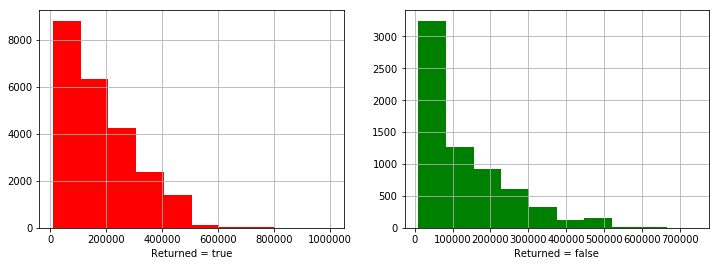

In [6]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(credit['LIMIT_BAL'][credit['default'] == 0], color = 'r')
pylab.xlabel('Returned = true')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(credit['LIMIT_BAL'][credit['default'] == 1], color = 'g')
pylab.xlabel('Returned = false')

pylab.show()

In [7]:
# -- A -- 
print '95%% confidence interval for the mean (Returned): [%f, %f]' % zconfint(credit_returned_true['LIMIT_BAL'])
print '95%% confidence interval for the mean (Not Returned): [%f, %f]' % zconfint(credit_returned_false['LIMIT_BAL'])

# -- B -- 
stats.mannwhitneyu(credit_returned_true['LIMIT_BAL'], credit_returned_false['LIMIT_BAL'])

95% confidence interval for the mean (Returned): [176411.914497, 179787.537651]
95% confidence interval for the mean (Not Returned): [127333.653340, 132885.659499]


MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

**Вывод**: среднее значение размера кредитного лимита выше у тех, кто в итоге вернул кредит. И критерий Манна-Уитни опровергает гипотезу о том что средние одинаковые. Результаты знечимы с практической точки зрения.

## Task 2

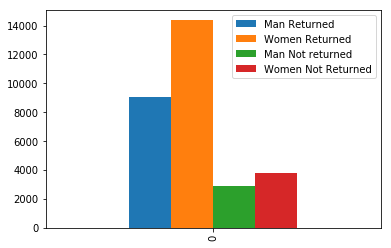

In [8]:
returned = credit['SEX'][credit['default'] == 0] - 1
not_returned = credit['SEX'][credit['default'] == 1] - 1

gender_stat = pd.DataFrame([[len(returned) - sum(returned),
                          sum(returned),
                          len(not_returned) - sum(not_returned),
                          sum(not_returned)]], 
                      columns = ["Man Returned", "Women Returned", "Man Not returned", "Women Not Returned"])

pylab.figure(figsize=(12,4))
gender_stat.plot.bar()
pylab.show()

In [9]:
# -- Confidence interval ---
conf_interval_returned_true = proportion_confint(sum(credit_returned_true['SEX']-1), 
                                            len(credit_returned_true['SEX']),
                                            method = 'wilson')
conf_interval_returned_false = proportion_confint(sum(credit_returned_false['SEX']-1), 
                                            len(credit_returned_false['SEX']),
                                            method = 'wilson')
print '95%% confidence interval for the mean (Returned): [%f, %f]' % conf_interval_returned_true
print '95%% confidence interval for the mean (Not Returned): [%f, %f]' % conf_interval_returned_false

# -- Stat Criteria ---

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(credit_returned_true['SEX']-1, 
                                                                              credit_returned_false['SEX']-1))

95% confidence interval for the mean (Returned): [0.607890, 0.620373]
95% confidence interval for the mean (Not Returned): [0.555102, 0.578938]
p-value: 0.000000


**Вывод:** из того что доверительные интервалы не пересекаются и того, что p-value очень низкий, делаем вывод что гендерный состав отличается (женщины более исправно выплачивают кредит).

## Task 3

In [10]:
# -- Посроим таблицу сопряженности
contingency_table = pd.crosstab(credit['EDUCATION'], credit['default'])
contingency_table

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


In [11]:
# Визуализируем процент невозвращенных кредитов в зависимости от образования
perc = []
credit_mean = float(sum(credit['default']))/len(credit['default'])
for i in range(0,7):
    perc.append(float(sum(credit[credit['EDUCATION'] ==  i]['default']))/ \
                len(credit[credit['EDUCATION'] ==  i]['default']))
noreturns_percent = pd.DataFrame([perc],columns=['доктор','магистр','бакалавр','выпускник школы','начальное образование','прочее','нет данных'])
noreturns_percent

,доктор,магистр,бакалавр,выпускник школы,начальное образование,прочее,нет данных
0,0.0,0.192348,0.237349,0.251576,0.056911,0.064286,0.156863


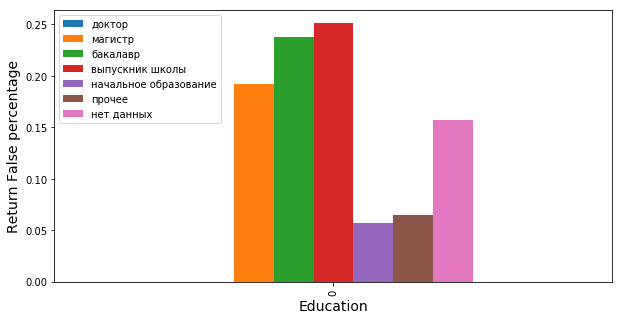

In [12]:
plt.figure(figsize(10,5))
noreturns_percent.plot.bar()
plt.xlabel('Education', fontsize=14)
plt.ylabel('Return False percentage', fontsize=14)
pylab.show()

In [13]:
# Посчитаем коэф-т Крамера и p-value
def v_cramer(contingency_table):
    chi2, p, dof, ex = scipy.stats.chi2_contingency(contingency_table)
    n = sum(sum(contingency_table))
    return np.sqrt(chi2 / (n*(min(shape(contingency_table))-1))), p

FC, pvalue = v_cramer(contingency_table)
print 'Коэф-т Крамера: %f; p-value: %f' % v_cramer(contingency_table)


Коэф-т Крамера: 0.073760; p-value: 0.000000


**Выводы:** 
    - Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости?
Ответ: как показано в датафрейме noreturns_percent - по каждой категории отобразить процент невозврата кредита
    - Наличие какого образования является наилучшим индикатором того, что человек отдаст долг?
Ответ: Доктор
    - наоборт, не отдаст долг?
Ответ: Выпускник школы

## Task 4